# Notes and Tasks

- Non-homogeneous mixing can be applied by editing the self.interact()

- We are assuming no recovery from HGT

- We need to make sure that acq bacteria reproduce res bacteria (state 2 => state 1)  

- The division function needs to be in the Bacteria Colony class to enforce carrying capacity

- We need to determine reproductive cycles and "life spans" for each bacteria

- The count_head() function needs to specify time step so we aren't counting all the bacteria that ever existed in the colony

In [1]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np 
import math
import pylab as pl
import math
import random as rd 
import copy

from mesa import Agent
from mesa import Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random

In [2]:
infection_rate = 0.1 # # probability of an infected bacteria transfering ARG to 
                      # adjcent susceptible bacteria
recovery_rate = 0.1 # probability of a infected bacteria to recover
arg_rate = 0.1 # probability of a bacteria to have ARG intitially

# Define agent Bacteria

In [3]:
class Bacteria(Agent):
    def __init__(self, unique_id,model,state=0,age=0,volume=0.1,tax='bac',gene_arg=None,mge=None):
        super().__init__(unique_id, model)
        self.unique_id = unique_id
        self.model = model
        self.state = state # 0 susceptible; 1 infected; 2 recovered
        self.age=age
        self.volume = volume
        self.tax = tax
        self.gene_arg = gene_arg
        self.mge = mge

    def step(self):
        self.random_move()
        self.divide()
        self.grow()
        self.interact()


    def random_move(self):
        ''' Bacteria can randomly move to nearby grids'''
        neighbor_pos = self.model.grid.get_neighborhood(self.pos, moore=True,include_center=False)
        new_pos = random.choice(neighbor_pos)
        self.model.grid.move_agent(self,new_pos)

    def grow(self):
        self.age += 1
        self.volume = 0.1 + self.age*0.005

    def divide(self):
        if self.volume == 0.2: # divide when the bacteria reaches 20 time steps
            self.age = 0
            new_born = Bacteria(self.model.num_agents+1,self.model,
            self.state,0,0.1,self.tax,self.gene_arg,self.mge) # inherit the genes from parent cell
            self.model.grid.place_agent(new_born,self.pos)
            self.model.schedule.add(new_born)
            self.model.num_agents += 1

    def interact(self):
        ''' interact with bacteria located in the same grid'''
        # search the agents located in the same grids

        if (self.state == 1) || (self.state== 2):
            x, y = self.pos
            this_cell = self.model.grid.get_cell_list_contents([self.pos])
            
            '''This would be where we would introduce nonhomogeneity'''
            susceptible_bacteria = [obj for obj in this_cell if obj.state==0]
            
            # randomly infected a susceptible_bacteria
            if len(susceptible_bacteria)>0:
                
                for each in susceptible_bacteria:
                    # randomly sample a number p, if p<infection rate, infection happens
                    p = random.uniform(0,1)
                    
                    ##implement horizontal gene transfer
                    if p< infection_rate:
                        each.state = 2
                        each.gene_arg = self.gene_arg


# Define model Bacteria_Colony

In [62]:
class Bacteria_Colony(Model):
    def __init__(self,N=100,width=10,height=10):
        super().__init__()
        self.num_agents = N
        self.width =width
        self.height = height
        self.grid = MultiGrid(width,height,True)

        self.schedule = RandomActivation(self)

        # DataCollector
        self.datacollector = DataCollector(
                # model level data
                model_reporters={
                 "PopSize":"N",
                 "Susceptible":lambda m: m.count_head(0),
                 "Infected": lambda m: m.count_head(1),
                 "Recovered": lambda m: m.count_head(2)},
                
                # agent level data
                agent_reporters={
                "State":"state",
                    "Age":"age",
                    "Volume":"volume",
                    "Taxonomy":"tax",
                    "ARG":"gene_arg",
                    "MGE":"mge"               
                }
                
        
        
        )
                 # m corresponds to the model, which is the argument of the function

        # create and assign agents
        coords_list = [(x,y) for x in range(width) for y in range(height)]

        for i in range(self.num_agents):
            # randomly assign the agent to a cell
            coords = random.choice(coords_list)
            #print(coords)
            p = random.uniform(0,1)
            if p<arg_rate:
                state = 1
            else:
                state = 0
            a = Bacteria(i,self,state)
            self.grid.place_agent(a, coords)
            self.schedule.add(a)

        #self.running=True
        #self.datacollector.collect(self)

    def step(self):      
        self.datacollector.collect(self) # collect model level data during each step
        self.schedule.step()
        #print(self.num_agents)
        #print(self.count_head(0))
        #print(self.count_head(1))
        #print(self.count_head(2))

    def run_model(self,step_count=200):
        for i in range(step_count):
            #print("The model is currently running step %d" % (i))
            self.step()

    '''We need to specify time step, so we arent looking at historical numbers (e.g. all sus bacteria that existed)'''        
    def count_head(self,state):
        # type 0: Susceptible, 1: Infected, 2: Recovered
        count = 0;
        tmp = self.schedule._agents
        for each in tmp.values():
            if each.state == state:
                count+=1
        return count
    
    
    '''STILL WORKING HERE | NOT FINISHED OR INTEGRATED'''
    def reproduce(self,sus_growth = 2,res_growth = 1.1,acq_growth = 1.1):
    ##Creates reproduced bacteria based on given bacteria
    ##MUST BE USED IN .APPLY() MANNER
    
        offspring = []

        if bac.state == 0:
            rep_rate = sus_growth

        elif bac.state == 1:
            rep_rate = res_growth

        elif bac.state == 2:
            rep_rate = acq_growth

        else:
            raise Exception("Unknown Bacteria Object state")


        for i in range(round(rep_rate)):
            offsp = copy.copy(bac)
            offsp.age = 0
            offspring.append(offsp)


        return offspring



In [66]:
col = list(model.schedule._agents.items())


[(0, <__main__.Bacteria at 0x1eb7953d470>),
 (1, <__main__.Bacteria at 0x1eb7953d4a8>),
 (2, <__main__.Bacteria at 0x1eb7953d588>),
 (3, <__main__.Bacteria at 0x1eb7953d4e0>),
 (4, <__main__.Bacteria at 0x1eb7953d518>),
 (5, <__main__.Bacteria at 0x1eb7953d550>),
 (6, <__main__.Bacteria at 0x1eb7953d7b8>),
 (7, <__main__.Bacteria at 0x1eb7953d828>),
 (8, <__main__.Bacteria at 0x1eb7953d908>),
 (9, <__main__.Bacteria at 0x1eb7953d940>),
 (10, <__main__.Bacteria at 0x1eb7953d860>),
 (11, <__main__.Bacteria at 0x1eb7953d898>),
 (12, <__main__.Bacteria at 0x1eb7953d8d0>),
 (13, <__main__.Bacteria at 0x1eb7953d978>),
 (14, <__main__.Bacteria at 0x1eb7953d9e8>),
 (15, <__main__.Bacteria at 0x1eb7953da20>),
 (16, <__main__.Bacteria at 0x1eb7953da58>),
 (17, <__main__.Bacteria at 0x1eb7953da90>),
 (18, <__main__.Bacteria at 0x1eb7953dac8>),
 (19, <__main__.Bacteria at 0x1eb7953db00>),
 (20, <__main__.Bacteria at 0x1eb7953db38>),
 (21, <__main__.Bacteria at 0x1eb7953d7f0>),
 (22, <__main__.Bact

# Test Zone

In [5]:
model = Bacteria_Colony()

In [6]:
model.run_model(step_count=10)

In [7]:
agents = model.datacollector.get_agent_vars_dataframe().reset_index()

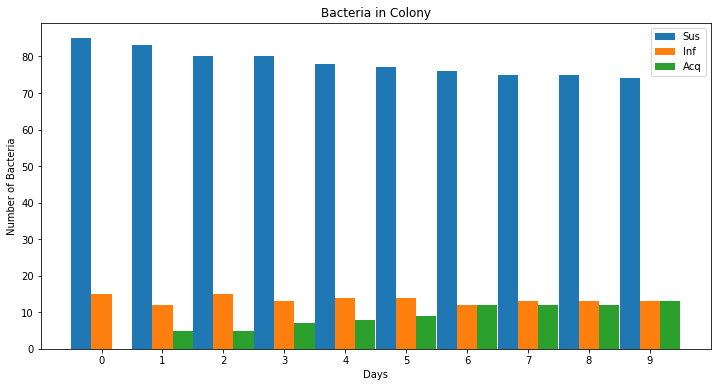

In [42]:
steps = len(agents.Step.drop_duplicates())
x = list(agents.Step.drop_duplicates())
y1 = []
y2 =[]
y0=[]

for i in range(steps):
    y0.append(len(agents.loc[(agents.Step == i)&(agents.State == 0)]))
    y1.append(len(agents.loc[(agents.Step == i)&(agents.State == 1)]))
    y2.append(len(agents.loc[(agents.Step == i)&(agents.State == 2)]))

width = 0.33 
    
plt.subplots(1,1,figsize=(12,6))
ax = plt.subplot(111)
ax.bar([t-width for t in x],y0,width=width,align='center')
ax.bar(x,y1,align='center',width=width)
ax.bar([t+width for t in x],y2,width=width,align='center')
ax.legend(['Sus','Inf','Acq'])
ax.set_xticks(x)
plt.title('Bacteria in Colony')
plt.ylabel('Number of Bacteria')
plt.xlabel('Days')

plt.show()

In [20]:
y2[6]

12